# Quantum state tomography

This notebook loosely follows through the examples in the [corresponding Qiskit tutorial](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/ignis/6a_state_tomography.ipynb). 

We perform quantum state tomography for two cases: a two-qubit Bell state, and a five-qubit GHZ state. 

These cells are used to 
    
   1. Import Qiskit (and ancillary packages) and display the available devices on IBMQ.
   2. Load a widget to track jobs sent to IBMQ.
   3. Choose the least busy device on IBMQ as our backend.

In [1]:
from qiskit import *

# Matplotlib is recommended for Qiskit.
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Load account (requires a saved IBMQ user id) and list available backends.
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [2]:
# Jupyter widget for tracking IBMQ jobs.
import qiskit.tools.jupyter
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

ibmqx2


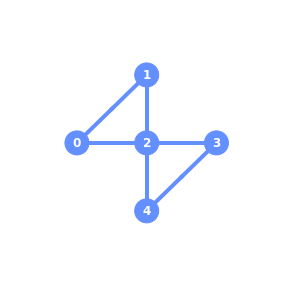

In [3]:
# Backend with right connectivity map for the five-qubit GHZ circuit.
backend = provider.get_backend('ibmqx2')

# Set qasm as simulator.
simulator = Aer.get_backend('qasm_simulator')

# Print name and configuration of backend.
from qiskit.visualization import plot_gate_map
print(backend)
plot_gate_map(backend)

## Example 1: Two-qubit Bell state

### Bell state preparation circuit

We construct two circuits. `bell` prepares a Bell state on two qubits, and `meas` measures the two qubits. 

The `execute` function on the backend requires `bell` + `meas`.

The `state_tomography_circuits` function from Ignis just requires `bell`.

In [4]:
# Circuit for two-qubit Bell state.
qr = QuantumRegister(2)
bell = QuantumCircuit(qr)
bell.h(0)
bell.cx(0, 1)
print(bell)

# Measurement circuit.
cr = ClassicalRegister(2)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure([0,1], [0,1])
print(bell+meas)

         ┌───┐     
q0_0: |0>┤ H ├──■──
         └───┘┌─┴─┐
q0_1: |0>─────┤ X ├
              └───┘
         ┌───┐      ░ ┌─┐   
q0_0: |0>┤ H ├──■───░─┤M├───
         └───┘┌─┴─┐ ░ └╥┘┌─┐
q0_1: |0>─────┤ X ├─░──╫─┤M├
              └───┘ ░  ║ └╥┘
 c0_0: 0 ══════════════╩══╬═
                          ║ 
 c0_1: 0 ═════════════════╩═
                            


### Output of the Bell state preparation circuit

To test the circuit, we run it on both the backend and simulator to verify that we have a Bell state.

In [5]:
# Run Bell circuit.
job = execute(bell+meas, backend, optimization_level=0, shots=5000)
counts = job.result().get_counts()
print(job.job_id())
print(counts)

# Simulate Bell circuit.
counts_sim = execute(bell+meas, simulator, shots=5000).result().get_counts()

5e4a0dc1b917c90018a16f61
{'01': 76, '00': 2253, '11': 2599, '10': 72}


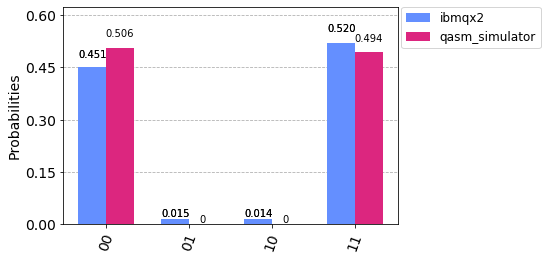

In [6]:
# Results from backend vs. simulator.
from qiskit.visualization import plot_histogram
fig, ax = plt.subplots(1, 1)
plot_histogram([counts, counts_sim], legend = [backend, simulator], ax = ax)

### Tomography on the Bell state

The `state_tomography_circuits` function gives us a list of circuits for `bell` that we then 
run on the backend. 

The `StateTomographyFitter` function fits the output to a density matrix.

In [7]:
# Circuits for state tomography.
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
qst_bell = state_tomography_circuits(bell, [qr[0], qr[1]])

for circ in qst_bell:
    print(circ)

         ┌───┐      ░ ┌───┐┌─┐   
q0_0: |0>┤ H ├──■───░─┤ H ├┤M├───
         └───┘┌─┴─┐ ░ ├───┤└╥┘┌─┐
q0_1: |0>─────┤ X ├─░─┤ H ├─╫─┤M├
              └───┘ ░ └───┘ ║ └╥┘
 c1_0: 0 ═══════════════════╩══╬═
                               ║ 
 c1_1: 0 ══════════════════════╩═
                                 
         ┌───┐      ░  ┌───┐ ┌─┐        
q0_0: |0>┤ H ├──■───░──┤ H ├─┤M├────────
         └───┘┌─┴─┐ ░ ┌┴───┴┐└╥┘┌───┐┌─┐
q0_1: |0>─────┤ X ├─░─┤ Sdg ├─╫─┤ H ├┤M├
              └───┘ ░ └─────┘ ║ └───┘└╥┘
 c1_0: 0 ═════════════════════╩═══════╬═
                                      ║ 
 c1_1: 0 ═════════════════════════════╩═
                                        
         ┌───┐      ░ ┌───┐┌─┐
q0_0: |0>┤ H ├──■───░─┤ H ├┤M├
         └───┘┌─┴─┐ ░ └┬─┬┘└╥┘
q0_1: |0>─────┤ X ├─░──┤M├──╫─
              └───┘ ░  └╥┘  ║ 
 c1_0: 0 ═══════════════╬═══╩═
                        ║     
 c1_1: 0 ═══════════════╩═════
                              
         ┌───┐      ░ ┌─────┐┌───┐┌─┐
q0_0: |0

In [8]:
# Tomography circuits on backend.
job = execute(qst_bell, backend, optimization_level=0, shots=5000)
print(job.job_id())

5e4a0ed5b917c90018a16f6b


0.8957037221907866


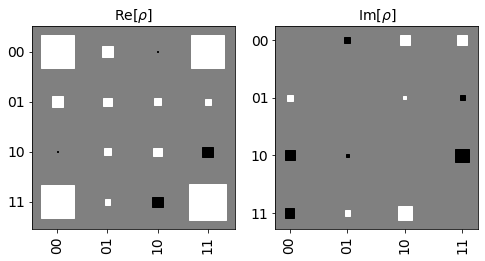

In [10]:
# Calculate density matrix.
tomo_bell = StateTomographyFitter(job.result(), qst_bell)
rho_bell = tomo_bell.fit()

# Calculate fidelity using statevector_simulator.
from qiskit.quantum_info import state_fidelity
psi_bell = execute(bell, Aer.get_backend('statevector_simulator')).result().get_statevector(bell)
print(state_fidelity(psi_bell[0:4], rho_bell))

# Hinton diagram of density matrix.
from qiskit.visualization import plot_state_hinton
plot_state_hinton(rho_bell)

## Example 2: Five-qubit GHZ state

This proceeds in a very similar way to the Bell state example.

A key difference is the the number of circuits required to state tomography `ghz` is far greater than `bell`.

This requires us to batch jobs.

### GHZ state preparation circuit

In [11]:
# Circuit for a five-qubit GHZ state.
qr = QuantumRegister(5)
ghz = QuantumCircuit(qr)
ghz.h(2)
for q in [0, 1, 3, 4]:
    ghz.cx(2, q)
print(ghz)

# Measurement circuit.
cr = ClassicalRegister(5)
meas = QuantumCircuit(qr, cr)
meas.barrier()
meas.measure(qr, cr)
print(ghz+meas)

              ┌───┐               
q1_0: |0>─────┤ X ├───────────────
              └─┬─┘┌───┐          
q1_1: |0>───────┼──┤ X ├──────────
         ┌───┐  │  └─┬─┘          
q1_2: |0>┤ H ├──■────■────■────■──
         └───┘          ┌─┴─┐  │  
q1_3: |0>───────────────┤ X ├──┼──
                        └───┘┌─┴─┐
q1_4: |0>────────────────────┤ X ├
                             └───┘
              ┌───┐                ░ ┌─┐            
q1_0: |0>─────┤ X ├────────────────░─┤M├────────────
              └─┬─┘┌───┐           ░ └╥┘┌─┐         
q1_1: |0>───────┼──┤ X ├───────────░──╫─┤M├─────────
         ┌───┐  │  └─┬─┘           ░  ║ └╥┘┌─┐      
q1_2: |0>┤ H ├──■────■────■────■───░──╫──╫─┤M├──────
         └───┘          ┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
q1_3: |0>───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                        └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
q1_4: |0>────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                             └───┘ ░  ║  ║  ║  ║ └╥┘
 c2_0: 0 ═══════════════════════

### Output of the GHZ preparation circuit

In [12]:
# Run GHZ circuit.
job = execute(ghz+meas, backend, optimization_level=1, shots=5000)
counts = job.result().get_counts()
print(job.job_id())
print(counts)

# Simulate GHZ circuit.
counts_sim = execute(ghz+meas, simulator, shots=5000).result().get_counts()

5e4a11d1f451ab00187eceec
{'00100': 6, '00000': 2395, '10110': 4, '11000': 3, '01111': 89, '10100': 6, '01001': 3, '11100': 26, '01110': 12, '10101': 4, '00001': 37, '11001': 2, '00011': 22, '11010': 5, '00101': 1, '11101': 103, '10011': 4, '10010': 3, '01101': 3, '00010': 19, '11011': 57, '01000': 105, '10000': 30, '01100': 1, '00111': 4, '01011': 16, '10111': 108, '11111': 1821, '01010': 1, '11110': 110}


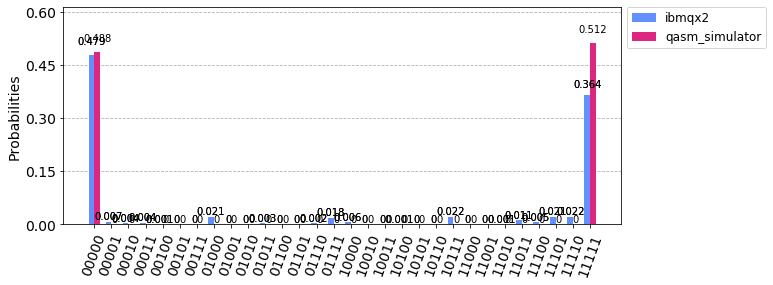

In [16]:
# Results from backend vs. simulator.
from qiskit.visualization import plot_histogram
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plot_histogram([counts, counts_sim], legend = [backend, simulator], ax = ax)

### Tomography on the GHZ state

In [17]:
# Calculate circuits for state tomography.
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
qst_ghz = state_tomography_circuits(ghz, qr)
print(len(qst_ghz))

243


In [22]:
import os

# State tomography circuits on backend.
result = [] 
for n in range(len(qst_ghz)//75 + 1): # Max circuits per job is 75.
    os.environ['QISKIT_IN_PARALLEL'] = 'TRUE' # This stops Qiskit yelling at me.
    job = execute(qst_ghz[n*75 : (n+1)*75], backend, optimization_level=0, shots=5000)
    result.append(job.result()) # Loop will pause until results can be retrieved.
    print(job.job_id())

5e4a24e7912c8200183cb338
5e4a2aab912c8200183cb365
5e4a2ef0ea11110018f0015f
5e4a33347bc87b001851711b


0.4524485973725113


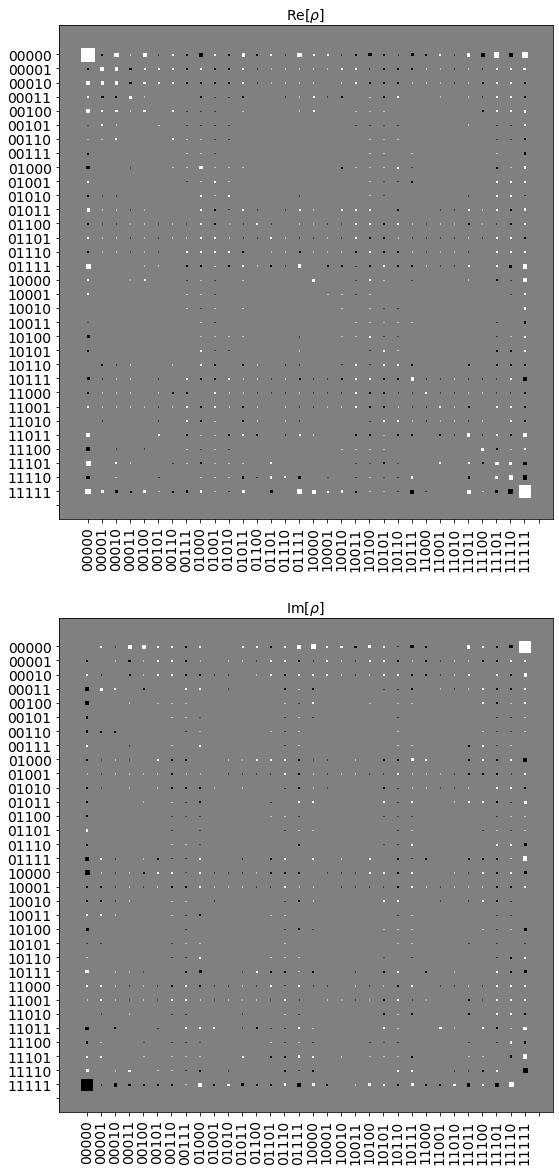

In [29]:
# Calculate density matrix.
tomo_ghz = []
tomo_ghz = StateTomographyFitter(result[0], qst_ghz[:75])
for n in range(1, len(qst_ghz)//75 + 1):
    tomo_ghz.add_data(result[n], qst_ghz[n*75 : (n+1)*75])
rho_ghz = tomo_ghz.fit()

# Calculate fidelity.
from qiskit.quantum_info import state_fidelity
psi_ghz = execute(ghz, Aer.get_backend('statevector_simulator')).result().get_statevector(ghz)
print(state_fidelity(psi_ghz[0:32], rho_ghz))

# Plot density matrix.
from qiskit.visualization import plot_state_hinton
fig, axs = plt.subplots(2, 1, figsize=(20, 20))
axs.flatten()
plot_state_hinton(rho_ghz, ax_real = axs[0], ax_imag = axs[1])